In [1]:
#Part 1

import pandas as pd

#read data and header file
field_name = pd.read_csv('./field_names.txt',header=None)
data = pd.read_csv('./breast-cancer.csv',header=None, names=list(field_name[0]))

In [7]:
#compute smoothness and compactness mean for benign and malignant tumors 
data.groupby('diagnosis')['smoothness_mean', 'compactness_mean'].mean()

,smoothness_mean,compactness_mean
diagnosis,,
B,2.000321,0.021438
M,4.323929,0.032281


In [8]:
#compute smoothness and compactness median for benign and malignant tumors
data.groupby('diagnosis')['smoothness_mean','compactness_mean'].median()

,smoothness_mean,compactness_mean
diagnosis,,
B,1.8510,0.01631
M,3.6795,0.02859


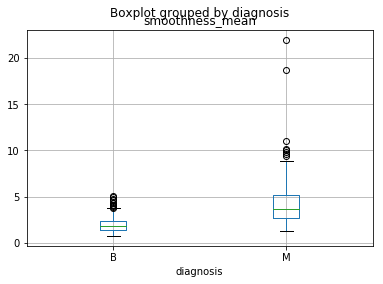

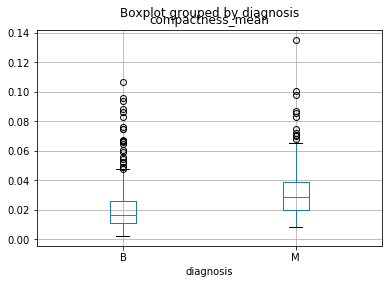

In [9]:
# Boxplot of smoothness and compactness fro benign and malignant tumors
import matplotlib.pyplot as plt

data.boxplot(column=['smoothness_mean'], by='diagnosis')
data.boxplot(column=['compactness_mean'], by='diagnosis')

plt.show()

In [6]:
from scipy.stats import ttest_ind

data_B = data[data['diagnosis']=='B']
data_M = data[data['diagnosis']=='M']

# t-test of smoonthness and their means are significantly different
ttest_ind(data_B['smoothness_mean'], data_M['smoothness_mean'])

Ttest_indResult(statistic=-15.934158019257902, pvalue=1.6519051758498057e-47)

In [10]:
# t-test of compactness and their means are significantly different
ttest_ind(data_B['compactness_mean'], data_M['compactness_mean'])

Ttest_indResult(statistic=-7.2970774374485305, pvalue=9.975994654074587e-13)

In [11]:
# bootstrapping function

import numpy as np

def bootstrap(data, num_samples=100):
    return data.iloc[np.random.choice(data.shape[1],num_samples)]

bootD = bootstrap(data,num_samples=1000)
bootD.shape

(1000, 32)

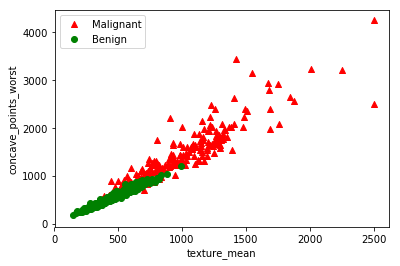

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X, y = data.iloc[:,2:], data.iloc[:,1]

#use univariate feature selection to identify two best features
Kbest = SelectKBest(chi2, k=2).fit(X, y)

XKbest = X.iloc[:,Kbest.get_support()]

#explore the relationship. The figure shows the two variables (texture_mean and concave_points_worst) are highly linear correlated

plt.scatter(XKbest[y=="M"][[0]], XKbest[y=="M"][[1]], marker='^',c='red',label='Malignant')
plt.scatter(XKbest[y=="B"][[0]], XKbest[y=="B"][[1]], marker='o',c='green',label='Benign')
plt.xlabel(XKbest.columns[0])
plt.ylabel(XKbest.columns[1])
plt.legend()

plt.show()

In [13]:
XKbest.columns

Index([u'texture_mean', u'concave_points_worst'], dtype='object')

In [14]:
# modelling - preprocessing: standardize predictors
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing

X, y = data.iloc[:,2:], data.iloc[:,1]

y = label_binarize(y, classes=["B","M"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train = y_train.ravel()
y_test = y_test.ravel()

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 



In [15]:
# Model 1: Logistic Regression
# Use L2 penalty to control overfitting
logreg = LogisticRegression(penalty='l2')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.9939741328630217
0.9978167704374545


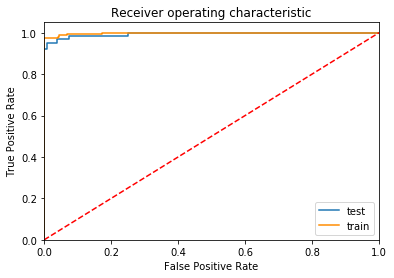

In [17]:
# evaluate Model 1 using AUC and ROC curves

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr_test, tpr_test, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
fpr_train, tpr_train, _ = roc_curve(y_train, logreg.predict_proba(X_train)[:,1])

print auc(fpr_test, tpr_test)

print auc(fpr_train, tpr_train)

#ROC curve
# AUC values for training and testing are close 1 and don't differ a lot. This shows the model works well (not over-fitted or under-fitted) 
plt.figure()
plt.plot(fpr_test, tpr_test, label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',label='train')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [18]:
#idenify the most important variable by the standardized coefficients
X.columns[np.argmax(np.abs(logreg.coef_))]

'area_sd_error'

In [20]:
# Model 2: Random Forest
# RF can limit overfitting by adding randomness into the data, i.e. random choosing variables to grow the tree and bootstrapping samples
# By tweaking the parameters such as minimum size of terminal nodes etc, we can control the overfitting 
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_split = 5, random_state=0)
clf.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score


# evaluate Model 2 using AUC
# The clasifier works not bad

fpr_test, tpr_test, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
fpr_train, tpr_train, _ = roc_curve(y_train, clf.predict_proba(X_train)[:,1])

print auc(fpr_test, tpr_test)

print auc(fpr_train, tpr_train)


0.9958847736625513
1.0


In [21]:
# Random Forest gives the importance of variables
X.columns[np.argmax(clf.feature_importances_)]

'fractal_dimension_mean'

In [22]:
# Explanation

#limitation
# For logistic regression, the corrleation between predictors are not accounted for, this may affect the coefficient estimation. It is possible to use PCR to furter enhance the analysis.
# For random forest, the parameters may not be optimal. We may use CV to further tweak the hyper-parmameters



In [ ]:
#Part 2



#Student Sample 1 .py

#!/usr/bin/env python

import pandas as pd
import numpy as np
from sklearn import LinearRegression # Wrong Inport. LinearRegression is under sklearn.linear_model module.
from sklearn.cross_validation import cross_val_score

# Load data
d = pd.read_csv('./data.train.csv')


# Setup data for prediction
x1 = data.SalaryNormalized  # Here, data is not defined. It should be d.   x1 is normally used to represent independent variable (predictor) instead of dependent variable (response)
x2 = pd.get_dummies(data.ContractType) #There are missing values in the data. may need to consider whether missing values can be treated as a seperate level or whether imputation is possible
#Notice the dummy variable trap. The dummy variables created by default are multicollinear. Consider to drop one of them.


# Setup model
model = LinearRegression()

# Evaluate model
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
scores = cross_val_score(model, x2, x1, cv=1, scoring='mean_absolute_error') #cross validation need to split data at least to two, i.e. cv >= 2
print(scores.mean())



#----------------------------------------------------------------------------

# Student Sample 2 .py
#!/usr/bin/env python

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

# Load data
data = pd.read_csv('../data/train.csv')


# Setup data for prediction
y = data.SalaryNormalized
X = pd.get_dummies(data.ContractType) 
#1.There are missing values in the data. may need to consider whether missing values can be treated as a seperate level or whether imputation is possible
#2.Notice the dummy variable trap. The dummy variables created by default are multicollinear. Consider to drop one of them.



# Setup model
model = LinearRegression()

# Evaluate model
scores = cross_val_score(model, X, y, cv=5, scoring='mean_absolute_error')
print(scores.mean())

